# General pipeline for generating results 

In [1]:
import ollama
import pandas as pd
import numpy as np
import constants    # custom module
import prompts      # custom module
import ast
import warnings
import re
from pprint import pprint
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score, multilabel_confusion_matrix
from statsmodels.stats import inter_rater as irr
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

df = pd.read_csv('data/balanced_data.csv', delimiter=";")

## Code

### Basic LLM prompt setup

In [2]:
model = 'llama3'

def run_prompt(prompt, input_text):
    response = ollama.chat(model='llama3', messages=[
        {
            'role': 'user',
            'content': prompt + input_text,
        },
    ])
    return response['message']['content']

def run_llm(prompt):
    responses = []
    for i, row in df.iloc[:constants.ANNOTATED_ROWS].iterrows():
        input_text = row['english']
        response = run_prompt(prompt, input_text)
        responses.append({'argument_id': row['id'],
                          'input_text': input_text,
                          'response': response})
    responses = pd.DataFrame(responses)
    return responses

### 5-run + aggregation pipeline

In [3]:
def five_run_pipeline(prompt):
    run_1 = run_llm(prompt)
    run_2 = run_llm(prompt)
    run_3 = run_llm(prompt)
    run_4 = run_llm(prompt)
    run_5 = run_llm(prompt)

    run_1_values = list(zip(run_1['argument_id'].tolist(), run_1['response'].apply(ast.literal_eval).tolist()))
    run_2_values = list(zip(run_2['argument_id'].tolist(), run_2['response'].apply(ast.literal_eval).tolist()))
    run_3_values = list(zip(run_3['argument_id'].tolist(), run_3['response'].apply(ast.literal_eval).tolist()))
    run_4_values = list(zip(run_4['argument_id'].tolist(), run_4['response'].apply(ast.literal_eval).tolist()))
    run_5_values = list(zip(run_5['argument_id'].tolist(), run_5['response'].apply(ast.literal_eval).tolist()))

    arg_ids = run_1['argument_id'].tolist()
    assert arg_ids == run_2['argument_id'].tolist() # Ensure the arg_ids are the same for all runs
    assert arg_ids == run_3['argument_id'].tolist()
    assert arg_ids == run_4['argument_id'].tolist()
    assert arg_ids == run_5['argument_id'].tolist()

    # create global dict of {arg_id: {value: count}}
    total_dict = {}
    for id in arg_ids:
        value_counts = {}
        for values in run_1_values + run_2_values + run_3_values + run_4_values + run_5_values:  # aggregate all values for this arg_id
            if id == values[0]:                 # if the arg_id matches
                for v in values[1]:             # iterate over sum of annotated values
                    if v in value_counts:       # count the occurences of each value
                        value_counts[v] += 1
                    else:
                        value_counts[v] = 1
        total_dict[id] = value_counts

    return total_dict

### Chain of Thought

In [17]:
def run_chain_of_thought(input_text, reasoning_prompt, prediction_prompt):
    reasoning = run_prompt(reasoning_prompt, input_text)
    prediction = run_prompt(prediction_prompt, reasoning)
    return prediction

def single_run_CoT(reasoning_prompt, prediction_prompt, run):
    responses = []
    for i, row in df.iloc[:constants.ANNOTATED_ROWS].iterrows():
    # for i, row in df.iloc[:3].iterrows():   # for testing
        print(f"Run {run} argument {i+1}/{constants.ANNOTATED_ROWS}")
        input_text = row['english']
        response = run_chain_of_thought(input_text, reasoning_prompt, prediction_prompt)
        responses.append({'argument_id': row['id'],
                          'input_text': input_text,
                          'response': regex_extract_values(response)})
    responses = pd.DataFrame(responses)
    return responses

# To deal with LLM returning other text
def regex_extract_values(response):
    regx = r"\[(.*?)\]"
    x = re.search(regx, response)
    if x:
        return "[" + x.group(1) + "]"
    else:
        return "['No value selected']"

def five_run_CoT(multi:bool = None):
    if multi:
        reasoning_prompt = prompts.CT_MV_REASONING
        prediction_prompt = prompts.CT_MV_PREDICTION
    else:
        reasoning_prompt = prompts.CT_SV_REASONING
        prediction_prompt = prompts.CT_SV_PREDICTION

    # Repeat the CoT pipeline 5 times
    run_1 = single_run_CoT(reasoning_prompt, prediction_prompt, 1)
    run_2 = single_run_CoT(reasoning_prompt, prediction_prompt, 2)
    run_3 = single_run_CoT(reasoning_prompt, prediction_prompt, 3)
    run_4 = single_run_CoT(reasoning_prompt, prediction_prompt, 4)
    run_5 = single_run_CoT(reasoning_prompt, prediction_prompt, 5)

    pprint(run_1)
    pprint(run_2)
    pprint(run_3)
    pprint(run_4)
    pprint(run_5)

    run_1_values = list(zip(run_1['argument_id'].tolist(), run_1['response'].apply(ast.literal_eval).tolist()))
    run_2_values = list(zip(run_2['argument_id'].tolist(), run_2['response'].apply(ast.literal_eval).tolist()))
    run_3_values = list(zip(run_3['argument_id'].tolist(), run_3['response'].apply(ast.literal_eval).tolist()))
    run_4_values = list(zip(run_4['argument_id'].tolist(), run_4['response'].apply(ast.literal_eval).tolist()))
    run_5_values = list(zip(run_5['argument_id'].tolist(), run_5['response'].apply(ast.literal_eval).tolist()))

    arg_ids = run_1['argument_id'].tolist()
    assert arg_ids == run_2['argument_id'].tolist() # Ensure the arg_ids are the same for all runs
    assert arg_ids == run_3['argument_id'].tolist()
    assert arg_ids == run_4['argument_id'].tolist()
    assert arg_ids == run_5['argument_id'].tolist()

    # create global dict of {arg_id: {value: count}}
    total_dict = {}
    for id in arg_ids:
        value_counts = {}
        for values in run_1_values + run_2_values + run_3_values + run_4_values + run_5_values:  # aggregate all values for this arg_id
            if id == values[0]:                 # if the arg_id matches
                for v in values[1]:             # iterate over sum of annotated values
                    if v in value_counts:       # count the occurences of each value
                        value_counts[v] += 1
                    else:
                        value_counts[v] = 1
        total_dict[id] = value_counts

    return total_dict

### Majority labels

In [5]:
def get_single_majority_labels(total_dict, threshold=None):
    """Get the majority labels for each argument id in the total_dict."""
    majority_labels = {}
    if threshold:
        for id, value_counts in total_dict.items():
            majority = max(value_counts.items(), key=lambda x: x[1])
            # print(f"{id}: ", majority[0], str(majority[1]))
            if majority[1] >= threshold:
                majority_labels[id] = majority[0]
            else:
                majority_labels[id] = 'None'
    else:
        for id, value_counts in total_dict.items():
            majority_labels[id] = max(value_counts, key=value_counts.get)
    return majority_labels

def get_multi_majority_labels(total_dict, threshold=None):
    """Get the majority labels for the multi-value LLM responses"""
    majority_labels = {}
    if threshold:   # Take all values above threshold
        for id, value_counts in total_dict.items():
            majority_labels[id] = [k for k, v in value_counts.items() if v >= threshold]
    else:           # Take all values
        for id, value_counts in total_dict.items():
            majority_labels[id] = list(value_counts.keys())
    return majority_labels

### Fleiss Kappa

In [6]:
def fleiss_kappa(total_dict):
    arg_ids = total_dict.keys()
    imagined_values = []

    # Creating a 2D array of annotations
    merged = pd.DataFrame(columns=[['argument_id'] + constants.VALUES])
    for id in arg_ids:
        merged.loc[id] = [id] + [0] * len(constants.VALUES)
        for v in total_dict[id].keys():
            if v in constants.VALUES:
                merged.loc[id, v] = total_dict[id][v]
            else:
                imagined_values.append(v)

    # Compute score
    fk = irr.fleiss_kappa(irr.aggregate_raters(merged[constants.VALUES])[0], method='fleiss')

    return fk

In [7]:
#!!! IMPORTANT: This function currently does not match the proper value label to the confusion matrix.
#    It just takes the .. first labels from the constants.VALUES list.
#    Thus, the labels do not match the matrices

def get_confusion_matrix(y_true, y_pred, labels):
    # Compute the multilabel confusion matrix
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # Calculate the number of rows needed for the subplots
    n_labels = mcm.shape[0]
    n_cols = 5
    n_rows = int(np.ceil(n_labels / n_cols))

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 20))

    # For each label, plot the confusion matrix
    for axes, cm, label in zip(ax.flatten(), mcm, labels):
        # im = axes.matshow(cm, cmap='viridis')  # Standard colorization
        im = axes.matshow(cm, cmap=plt.cm.Blues)   # Plot the confusion matrix
        fig.colorbar(im, ax=axes)  # Add a colorbar
        axes.set(title=label)  # Set the title to the label name

        axes.set_xlabel('Predicted')
        axes.set_ylabel('Actual')
        axes.set_xticklabels(['', 'P', 'N'])
        axes.set_yticklabels(['', 'P', 'N'])

        # Add the values of the confusion matrix to the squares
        for (i, j), z in np.ndenumerate(cm):
            axes.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

    # If there are fewer labels than subplots, remove the extra subplots
    if n_labels < n_rows * n_cols:
        for axes in ax.flatten()[n_labels:]:
            fig.delaxes(axes)

    plt.tight_layout()  # Ensure the subplots do not overlap
    plt.show()  # Display the figure

### Get scores

In [8]:
def get_scores(total_dict, method, threshold: int = None, confusion_matrix: bool = None):
    # SINGLE value predictions
    if "sv" in method:
        if threshold:   # Compare to threshold ground truth labels
            y_pred = get_single_majority_labels(total_dict, threshold).values()
            y_true = constants.FRYSIAN_MAJORITY_LABELS_T3.values()
        else:
            y_pred = get_single_majority_labels(total_dict).values()
            y_true = constants.FRYSIAN_MAJORITY_LABELS.values()

    # MULTI value predictions
    if "mv" in method:
        if threshold:
            y_pred = get_multi_majority_labels(total_dict, threshold).values()
            y_true = get_multi_majority_labels(constants.ANNOTATIONS, threshold).values()
        else:
            y_pred = get_multi_majority_labels(total_dict).values()
            y_true = get_multi_majority_labels(constants.ANNOTATIONS).values()

    mlb = MultiLabelBinarizer()
    y_true = mlb.fit_transform(y_true)
    y_pred = mlb.transform(y_pred)

    decimal_places = 3

    t = PrettyTable(['Metric', 'Weighted', 'Micro'])
    t.add_row(['Precision',
                round(precision_score(y_true, y_pred, average='weighted'), decimal_places),
                round(precision_score(y_true, y_pred, average='micro'), decimal_places)])
    t.add_row(['Recall',
                round(recall_score(y_true, y_pred, average='weighted'), decimal_places),
                round(recall_score(y_true, y_pred, average='micro'), decimal_places)])
    t.add_row(['F1',
                round(f1_score(y_true, y_pred, average='weighted'), decimal_places),
                round(f1_score(y_true, y_pred, average='micro'), decimal_places)])
    print(t, '\n')

    # Confusion matrix
    if confusion_matrix:
        get_confusion_matrix(y_true, y_pred, labels=y_true)

    # return f1_score(y_true, y_pred, average=None)

In [9]:
# For the runs per annotator
def get_annotator_scores(responses, annotator, print_scores: bool = False):
    y_true = []
    y_pred = []

    for id in responses.keys():
        y_true.append(constants.ANNOTATIONS_PER_ANNOTATOR[str(id)]['annotator_1'])
        y_pred.append(responses[id])

    mlb = MultiLabelBinarizer()
    y_true = mlb.fit_transform(y_true)
    y_pred = mlb.transform(y_pred)

    decimal_places = 3

    precision = round(precision_score(y_true, y_pred, average='weighted'), decimal_places)
    recall = round(recall_score(y_true, y_pred, average='weighted'), decimal_places)
    f1 = round(f1_score(y_true, y_pred, average='weighted'), decimal_places)

    if print_scores:
        print(f"Scores for {annotator}:")

        t = PrettyTable(['Metric', 'Weighted', 'Micro'])
        t.add_row(['Precision',
                    precision,
                    round(precision_score(y_true, y_pred, average='micro'), decimal_places)])
        t.add_row(['Recall',
                    recall,
                    round(recall_score(y_true, y_pred, average='micro'), decimal_places)])
        t.add_row(['F1',
                    f1,
                    round(f1_score(y_true, y_pred, average='micro'), decimal_places)])

    return (precision, recall, f1)

### Capturing subjectivity per annotator 

In [10]:
def per_annotator(annotator: str, training: int, test: int, print_scores: bool = False):
    # For 30 data points, show what each annotator has annotated
    messages = []

    messages.append({
        'role': 'system',
        'content': """
            Your task will be to identify the underlying values for a given piece of text and a list of possible values, as a human would do it.
            First I will give some examples of what a human has annotated, and after that I will ask you to predict what that human would have annotated for a new piece of text.
        """,
    })

    ##### Provide examples
    for i in range(training):
        arg = df.iloc[i]
        # pprint(f"{annotator} {arg['id']}: {constants.ANNOTATIONS_PER_ANNOTATOR[str(arg['id'])][annotator]}")
        messages.append({   # Argument statement
            'role': 'user',
            'content': f"""
                What are the underlying human values for this argument statement?
                "{arg['english']}"
            """,
        })
        messages.append({   # Annotator's given values for that argument
            'role': 'assistant',
            'content': f"""
                {constants.ANNOTATIONS_PER_ANNOTATOR[str(arg['id'])][annotator]}
            """
        })

    responses = {}

    # For 20 data points, ask for prediction per annotator
    for i in range(training, training + test):
        arg = df.iloc[i]
        messages.append({
            'role': 'system',
            'content': f"""
                Now that you have seen how this human annotates values, I will ask you to predict what this human would have annotated for a new piece of text.
                - The answers must be any of these possible values that you think apply, using their exact wording from this list: {constants.VALUES}.
                - If none of the values match, you may respond with 'None'.
                - The responses must be given in the format of a Python list, e.g., ["be ...", "have ..."], or ["None"] if no values apply.
                - Do not provide any explanation, additional text, or any values not present in the list.
            """,
        })
        messages.append({
            'role': 'user',
            'content': f"""
                What are the underlying human values for this argument statement?
                "{arg['english']}"
            """,
        })

        ##### Run it
        response = ollama.chat(model='llama3', messages=messages)
        response_content = response['message']['content']

        # Convert string representation of list to list
        response_list = ast.literal_eval(response_content)
        responses.update({arg['id']: response_list})
        # print(f"{arg['id']}: {response_list}")

        # Clear the messages for the next prediction
        messages = []


    # Compare to human annotation
    scores = get_annotator_scores(responses, annotator, print_scores)

    return [responses, scores]

In [ ]:
def five_run_annotator(annotator):
    scores = []
    for i in range(5):
        ann = per_annotator(annotator, 30, 20, print_scores=False)
        print(f"{annotator} run {i}: {ann[1]}")
        scores.append(ann[1])

    pr_total = 0
    re_total = 0
    f1_total = 0
    for i, score in enumerate(scores):
        pr_total += score[0]
        re_total += score[1]
        f1_total += score[2]

    pr_avg = round(pr_total / len(scores), 3)
    re_avg = round(re_total / len(scores), 3)
    f1_avg = round(f1_total / len(scores), 3)

    print(f"Average scores for {annotator}:")
    print(f"Precision: {pr_avg}")
    print(f"Recall: {re_avg}")
    print(f"F1: {f1_avg}")

## Running for each prompting method
- Zero shot, single value
- Zero shot, multiple value
- Few shot, single value
- Few shot, multiple value
- Chain of thought, single value
- Chain of thought, multiple value

In [11]:
# Zero-shot, single value
# zs_sv = five_run_pipeline(prompts.ZS_SV)

In [12]:
# Zero shot, multiple value
# zs_mv = five_run_pipeline(prompts.ZS_MV)

In [13]:
# Few shot, single value
# fs_sv = five_run_pipeline(prompts.FS_SV)

In [14]:
# Few shot, multiple value
# fs_mv = five_run_pipeline(prompts.FS_MV)

In [1]:
# Chain of thought, single value  ------ Takes 50 mins to run
# CT_SV = five_run_CoT()

### Fleiss kappa 

In [ ]:
print("Zero-shot Single: ", fleiss_kappa(constants.ZS_SV))
print("Zero-shot Multi: ", fleiss_kappa(constants.ZS_MV))
print("Few-shot Single: ", fleiss_kappa(constants.FS_SV))
print("Few-shot Multi: ", fleiss_kappa(constants.FS_MV))
print("Chain of Thought Single: ", fleiss_kappa(constants.CT_SV))

Zero-shot Single:  -0.00037050759530815597
Zero-shot Multi:  0.003658982781930174
Few-shot Single:  -0.004301373195649773
Few-shot Multi:  0.004795694979931359
Chain of Thought Single:  -0.0064323467985471765


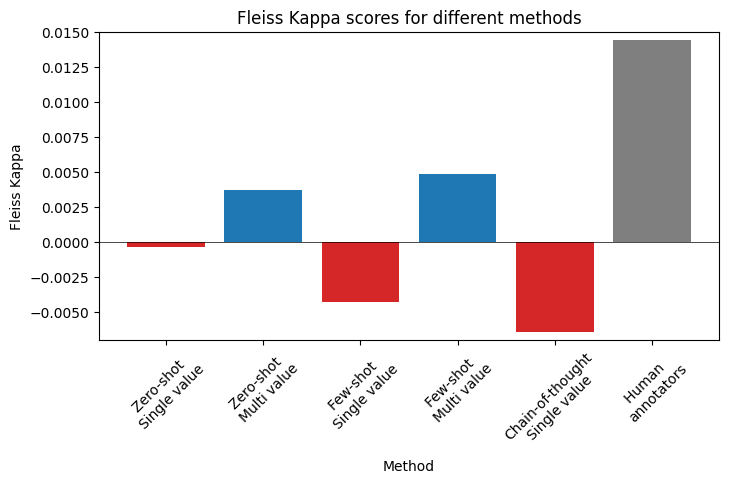

In [ ]:
fig = plt.figure(figsize=(8, 4))
plt.bar(['Zero-shot \nSingle value', 'Zero-shot \nMulti value', 'Few-shot \nSingle value', 'Few-shot \nMulti value', 'Chain-of-thought\nSingle value', "Human \nannotators"],
        [fleiss_kappa(constants.ZS_SV), fleiss_kappa(constants.ZS_MV), fleiss_kappa(constants.FS_SV), fleiss_kappa(constants.FS_MV), fleiss_kappa(constants.CT_SV), constants.FLEISS_KAPPA_50],
        color=['tab:red', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red', 'tab:gray'])
plt.xticks(rotation=45)
plt.ylim(-0.007, 0.015)
plt.axhline(0, color='black', linewidth=.5)
plt.xlabel('Method')
plt.ylabel('Fleiss Kappa')
plt.title('Fleiss Kappa scores for different methods')
plt.show()

### Calculating scores

In [ ]:
warnings.simplefilter('ignore')

def run_scores():
    ## Zero shot
    # print("zero-shot single:", "\n")
    # print("Fleiss kappa: ", fleiss_kappa(zs_sv), "\n")
    # get_scores(constants.ZS_SV, "zs_sv")

    # print("zero-shot single T=3", "\n")
    # get_scores(constants.ZS_SV, "zs_sv", 3)

    # print("zero-shot multi:", "\n")
    # print("Fleiss kappa: ", fleiss_kappa(zs_mv), "\n")
    # get_scores(constants.ZS_MV, "zs_mv")

    # print("zero-shot multi T=3:", "\n")
    # get_scores(constants.ZS_MV, "zs_mv", 3)

    # ## Few shot
    # print("few-shot single:", "\n")
    # print("Fleiss kappa: ", fleiss_kappa(fs_sv), "\n")
    # get_scores(constants.FS_SV, "fs_sv")

    # print("few-shot single T=3", "\n")
    # get_scores(constants.FS_SV, "fs_sv", 3)

    # print("few-shot multi:", "\n")
    # print("Fleiss kappa: ", fleiss_kappa(fs_mv), "\n")
    # get_scores(constants.FS_MV, "fs_mv")

    # print("few-shot multi T=3:", "\n")
    # get_scores(constants.FS_MV, "fs_mv", 3)

    ## Chain of Thought
    # print("Chain of thought single:", "\n")
    # get_scores(constants.CT_SV, "sv")

    # print("Chain of thought single T=3:", "\n")
    # get_scores(constants.CT_SV, "sv", 3)

# Uncomment to print the scores
run_scores()

Chain of thought single: 

+-----------+----------+-------+
|   Metric  | Weighted | Micro |
+-----------+----------+-------+
| Precision |   0.62   | 0.596 |
|   Recall  |  0.603   | 0.603 |
|     F1    |  0.594   |  0.6  |
+-----------+----------+-------+ 

Chain of thought single T=3: 

+-----------+----------+-------+
|   Metric  | Weighted | Micro |
+-----------+----------+-------+
| Precision |   0.58   |  0.58 |
|   Recall  |  0.495   | 0.495 |
|     F1    |  0.522   | 0.534 |
+-----------+----------+-------+ 



## Prediction per annotator

In [ ]:
# ann_1 = per_annotator('annotator_1', 30, 20, print_scores=False)
# annotator_1_res = ann_1[0]
# print(f"Annotator 1 scores: {ann_1[1]}")

In [ ]:
# ann_2 = per_annotator('annotator_2', 30, 20, print_scores=False)
# annotator_2_res = ann_2[0]
# print(f"Annotator 2 scores: {ann_2[1]}")

In [ ]:
# ann_3 = per_annotator('annotator_3', 30, 20, print_scores=False)
# annotator_3_res = ann_3[0]
# print(f"Annotator 3 scores: {ann_3[1]}")

In [ ]:
# ann_4 = per_annotator('annotator_4', 30, 20, print_scores=False)
# annotator_4_res = ann_4[0]
# print(f"Annotator 4 scores: {ann_4[1]}")

In [ ]:
# ann_5 = per_annotator('annotator_5', 30, 20, print_scores=False)
# annotator_5_res = ann_5[0]
# print(f"Annotator 5 scores: {ann_5[1]}")

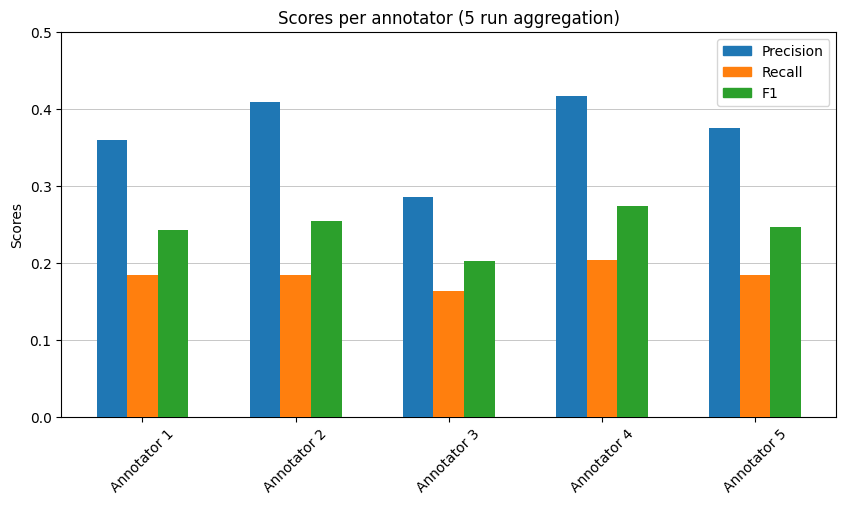

In [ ]:
fig = plt.figure(figsize=(10, 5))

# Define the labels and data
labels = ['Annotator 1', 'Annotator 2', 'Annotator 3', 'Annotator 4', 'Annotator 5']
# labels = ['Annotator 1\nJoosje', 'Annotator 2\nBente', 'Annotator 3\nTimur', 'Annotator 4\nAna', 'Annotator 5\nAdina']
data = [(0.36, 0.184, 0.243), (0.409, 0.184, 0.254), (0.286, 0.163, 0.203), (0.417, 0.204, 0.274), (0.375, 0.184, 0.247)]
# data = [ann_1[1], ann_2[1], ann_3[1], ann_4[1], ann_5[1]]

# Calculate the width of each bar and the positions of the bars
num_bars = len(data[0])
bar_width = 0.2
x = np.arange(len(labels))

# Plot each group of bars
for i in range(num_bars):
    heights = [group[i] for group in data]
    plt.bar(x + i*bar_width, heights, width=bar_width, zorder=3)

# Set the x-ticks to be the center of each group of bars
plt.xticks(x + bar_width*(num_bars-1)/2, labels)
plt.xticks(rotation=45)

plt.ylim(0, 0.5)
plt.ylabel("Scores")
plt.title("Scores per annotator (5 run aggregation)")

# Manually set legend
blue_patch = mpatches.Patch(color='tab:blue', label='Precision')
orange_patch = mpatches.Patch(color='tab:orange', label='Recall')
green_patch = mpatches.Patch(color='tab:green', label='F1')
plt.legend(handles=[blue_patch, orange_patch, green_patch])

plt.grid(axis='y', linewidth=0.5, zorder=0)

plt.show()